# PawNet-U: Pet Image Segmentation with U-Net (Oxford-IIIT Pets)

Pixel-wise segmentation of cats & dogs into **background / pet / border** using a compact U-Net in Keras/TensorFlow.

**Why it matters:** segmentation teaches models to understand *where* objects are, not just *what* they are.

**Repo highlights:** Data loading with `tf.keras.utils.Sequence` · Lightweight U-Net · Clear visual results

## What you’ll see in this notebook
1. **Dataset setup** — download Oxford-IIIT Pets and align images with trimap masks  
2. **Quick visualization** — one photo next to its mask (3 classes)  
3. **Data loader** — a `Sequence` generator for efficient batching  
4. **U-Net** — concise encoder–decoder with skip connections  
5. **Training & metrics** — loss/accuracy, parameter count, model summary  
6. **Qualitative results** — prediction vs. ground truth trimaps  
7. **Notes & limitations** — what works, where it struggles, ideas to improve


# Setup & Imports

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Threading guards (optional but recommended on macOS/M1 — put BEFORE numpy/tf imports)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Core libs
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random
import ntpath

# TensorFlow / Keras (use ONLY tf.keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Activation,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets import mnist

# 1. Dataset setup — download Oxford-IIIT Pets and align images with trimap masks

In [2]:
import pathlib, tarfile
from tensorflow.keras.utils import get_file

# Correct URLs (note the extra "/data/" segment)
images_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

# Local root folder
root_dir = pathlib.Path("oxfordpets")
root_dir.mkdir(exist_ok=True)

# Download archives (no wget needed)
images_path = get_file("images.tar.gz", origin=images_url, cache_dir=root_dir, extract=False)
annotations_path = get_file("annotations.tar.gz", origin=annotations_url, cache_dir=root_dir, extract=False)

# Extract with Python's tarfile (no shell tar needed)
with tarfile.open(images_path, "r:gz") as tar:
    tar.extractall(path=root_dir)

with tarfile.open(annotations_path, "r:gz") as tar:
    tar.extractall(path=root_dir)

print("Data extracted to:", root_dir)

# Update your paths for the rest of your code
input_dir = str(root_dir / "images")
target_dir = str(root_dir / "annotations" / "trimaps")
print("input_dir:", input_dir)
print("target_dir:", target_dir)


Data extracted to: oxfordpets
input_dir: oxfordpets/images
target_dir: oxfordpets/annotations/trimaps


In [3]:
# These were set in the previous block:
# root_dir = pathlib.Path("oxfordpets")
# after extraction we have: root_dir/images and root_dir/annotations/trimaps

input_dir  = root_dir / "images"
target_dir = root_dir / "annotations" / "trimaps"

img_size    = (160, 160)
num_classes = 3
batch_size  = 32

# Collect files
input_paths  = sorted(p for p in input_dir.glob("*.jpg") if not p.name.startswith("."))
target_paths = sorted(p for p in target_dir.glob("*.png") if not p.name.startswith("."))

# Align by filename stem to avoid mismatches
inputs_by_stem  = {p.stem: p for p in input_paths}
targets_by_stem = {p.stem: p for p in target_paths}
common_stems    = sorted(set(inputs_by_stem) & set(targets_by_stem))

input_img_paths  = [str(inputs_by_stem[s])  for s in common_stems]
target_img_paths = [str(targets_by_stem[s]) for s in common_stems]

print("Number of samples:", len(input_img_paths))
for inp, tgt in list(zip(input_img_paths, target_img_paths))[:10]:
    print(inp, "|", tgt)


Number of samples: 7390
oxfordpets/images/Abyssinian_1.jpg | oxfordpets/annotations/trimaps/Abyssinian_1.png
oxfordpets/images/Abyssinian_10.jpg | oxfordpets/annotations/trimaps/Abyssinian_10.png
oxfordpets/images/Abyssinian_100.jpg | oxfordpets/annotations/trimaps/Abyssinian_100.png
oxfordpets/images/Abyssinian_101.jpg | oxfordpets/annotations/trimaps/Abyssinian_101.png
oxfordpets/images/Abyssinian_102.jpg | oxfordpets/annotations/trimaps/Abyssinian_102.png
oxfordpets/images/Abyssinian_103.jpg | oxfordpets/annotations/trimaps/Abyssinian_103.png
oxfordpets/images/Abyssinian_104.jpg | oxfordpets/annotations/trimaps/Abyssinian_104.png
oxfordpets/images/Abyssinian_105.jpg | oxfordpets/annotations/trimaps/Abyssinian_105.png
oxfordpets/images/Abyssinian_106.jpg | oxfordpets/annotations/trimaps/Abyssinian_106.png
oxfordpets/images/Abyssinian_107.jpg | oxfordpets/annotations/trimaps/Abyssinian_107.png


# 2. Quick visualization — one photo next to its mask (3 classes)

# 2. Quick visualization — one photo next to its mask (3 classes)

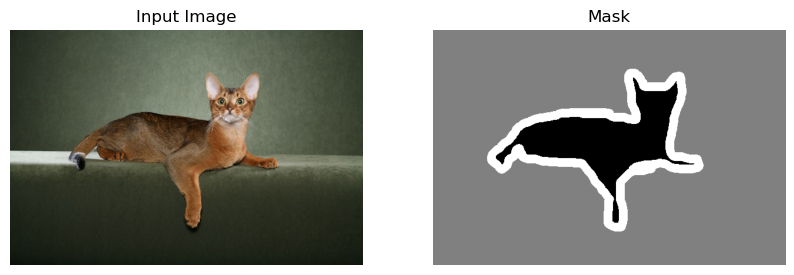

In [4]:
# Visualize one image and its mask
def visualize_sample():
    sample_image = input_img_paths[0]
    sample_mask = target_img_paths[0]

    image = load_img(sample_image)
    mask = load_img(sample_mask, color_mode="grayscale")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()

visualize_sample()

# 3. Data loader — a Sequence generator for efficient batching

In [13]:
class OxfordPets(tf.keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) 

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

# 4. U-Net — concise encoder–decoder with skip connections

In [14]:
# Define the U-Net architecture
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    # Contracting path
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    previous_block_activation = x

    for filters in [64]:
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2, strides=2)(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    # Expansive path
    for filters in [64, 32]:
        x = layers.Conv2DTranspose(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    return tf.keras.Model(inputs, outputs)

# 5. Training & metrics — loss/accuracy, parameter count, model summary

In [15]:
# Create the model
num_classes = 3
unet = get_model(img_size, num_classes)
unet.summary()

2025-08-18 23:53:35.844565: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-08-18 23:53:35.844610: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-18 23:53:35.844632: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-18 23:53:35.844672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-18 23:53:35.844684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 80,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 40, 40,    │      2,112 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 40, 40,    │     36,928 │ add[0][0]         │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 40, 40,    │     36,928 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 80, 80,    │          0 │ add[0][0]         │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 80,    │      4,160 │ up_sampling2d_1[

 Total params: 168,515 (658.26 KB)

 Trainable params: 167,811 (655.51 KB)

 Non-trainable params: 704 (2.75 KB)

In [16]:
val_samples = 1000
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [17]:
train_gen = OxfordPets(1, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(1, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
unet.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = unet.fit(train_gen, epochs=5, validation_data=val_gen)

Epoch 1/5


/opt/anaconda3/envs/tf-m1/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-08-18 23:54:01.806253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


6390/6390 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6783 - loss: 0.7685   

/opt/anaconda3/envs/tf-m1/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6390/6390 ━━━━━━━━━━━━━━━━━━━━ 2142s 334ms/step - accuracy: 0.7270 - loss: 0.6583 - val_accuracy: 0.7303 - val_loss: 0.7718
Epoch 2/5
 299/6390 ━━━━━━━━━━━━━━━━━━━━ 13:44 135ms/step - accuracy: 0.7792 - loss: 0.5492

# 6. Qualitative results — prediction vs. ground truth trimaps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


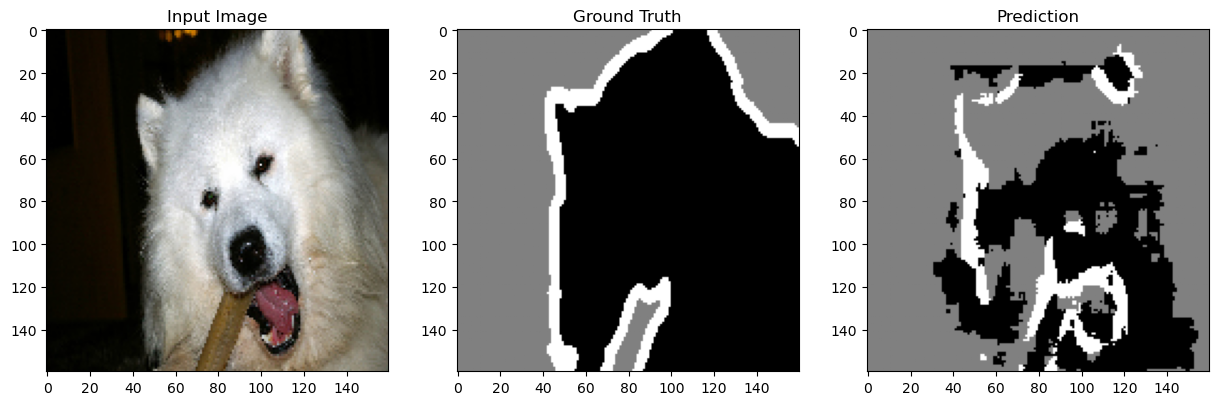

In [19]:
# Evaluate the model
def evaluate_model():
    x, y = val_gen[0]
    predictions = unet.predict(x)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(x[0].astype('uint8'))

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y[0].squeeze(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(np.argmax(predictions[0], axis=-1), cmap="gray")
    plt.show()

evaluate_model()

### What works
- Learns pet vs. background reliably on most breeds
- Borders are reasonable when contrast is high

### What’s hard
- Fine hair/whiskers; thin tails
- Busy backgrounds with similar colors
- Small or partially occluded pets

### Next steps (future work)
- Dice loss / Jaccard loss (IoU) for class imbalance
- Data augmentation (flips, random crops) to generalize better
- Deeper U-Net or attention gates for tricky edges